In [1]:
import os
os.chdir('/Users/yinancheng/Documents/Project/TrustworthyAI/Advertisement/')

Load data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = 'Data' # Path of the dataset folder

df_feeds = pd.read_csv(path + '/train/train_data_feeds.csv')
df_ads = pd.read_csv(path + '/train/train_data_ads.csv')

print(df_feeds.shape)
print(df_ads.shape)

(3227732, 28)
(7675517, 35)


Last touch point matching

In [3]:
user_ads = df_ads['user_id'].unique() #get potential customer's user id

#feeds data: select potential customers and sort by timestamp
df_feeds_pot = df_feeds[df_feeds['u_userId'].isin(user_ads)].sort_values(by='e_et')

#ads data: sort by timestamp
df_ads = df_ads.sort_values(by = 'pt_d')
#merge above selected data via last touch point
df_merged = pd.merge_asof(df_ads, df_feeds_pot, left_on='pt_d', right_on='e_et',\
                          left_by = 'user_id', right_by = 'u_userId', direction='backward')

#shuffle the merged dataset
df_merged = df_merged.sample(frac=1, random_state = 0).reset_index(drop=True)

# 1 Match Rate/Drop Rate Analysis

### 1.1 Whole data

Match rate and drop rate

In [4]:
df_matched = df_merged.dropna()
match_rate = df_matched.shape[0]/df_merged.shape[0]
drop_rate = 1-match_rate
print("match rate:",match_rate)
print("drop rate:",drop_rate)

match rate: 0.8307807799787298
drop rate: 0.1692192200212702


Label rate changes

In [5]:
print('Merged data label 1 rate:',df_merged['label_x'].mean())
print('Matched data label 1 rate:',df_matched['label_x'].mean())

Merged data label 1 rate: 0.01552156030662169
Matched data label 1 rate: 0.01305367439316308


### 1.2 Per User

Per-user match rate

In [6]:
drop_rate_user = df_merged.groupby('user_id').apply(lambda x: x.isna().any(axis = 1).mean())
match_rate_user = 1 - drop_rate_user

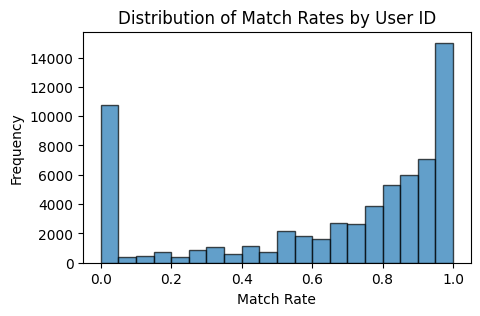

In [7]:
plt.figure(figsize=(5, 3))
plt.hist(match_rate_user, bins = 20, edgecolor='k', alpha = 0.7)
plt.title('Distribution of Match Rates by User ID')
plt.xlabel('Match Rate')
plt.ylabel('Frequency')
plt.show()

Per-user label change

In [8]:
label_rate_merged_user = df_merged.groupby('user_id').apply(lambda x: x['label_x'].mean())
label_rate_matched_user = df_matched.groupby('user_id').apply(lambda x: x['label_x'].mean())

In [9]:
label_rate_change_user = label_rate_matched_user - label_rate_merged_user

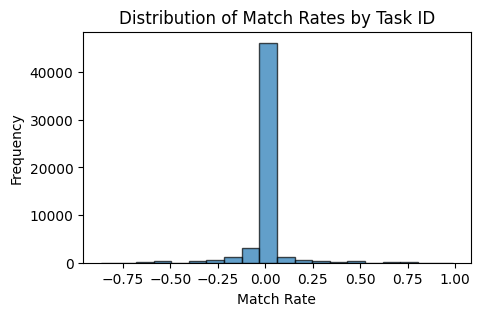

In [10]:
plt.figure(figsize=(5, 3))
plt.hist(label_rate_change_user.dropna(), bins = 20, edgecolor='k', alpha = 0.7)
plt.title('Distribution of Match Rates by Task ID')
plt.xlabel('Match Rate')
plt.ylabel('Frequency')
plt.show()

### 1.3 Per Task 

Per-task match rate

In [11]:
drop_rate_task = df_merged.groupby('task_id').apply(lambda x: x.isna().any(axis = 1).mean())
match_rate_task = 1 - drop_rate_task

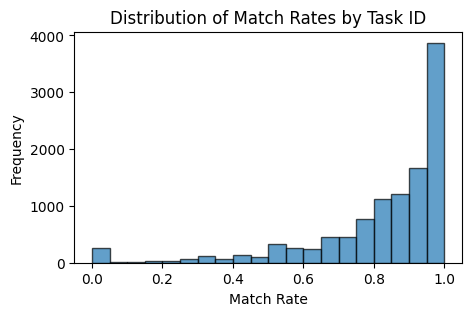

In [12]:
plt.figure(figsize=(5, 3))
plt.hist(match_rate_task, bins = 20, edgecolor='k', alpha = 0.7)
plt.title('Distribution of Match Rates by Task ID')
plt.xlabel('Match Rate')
plt.ylabel('Frequency')
plt.show()

Per-task label change

In [13]:
label_rate_merged_task = df_merged.groupby('task_id').apply(lambda x: x['label_x'].mean())
label_rate_matched_task = df_matched.groupby('task_id').apply(lambda x: x['label_x'].mean())

In [14]:
label_rate_change_task = label_rate_matched_task - label_rate_merged_task

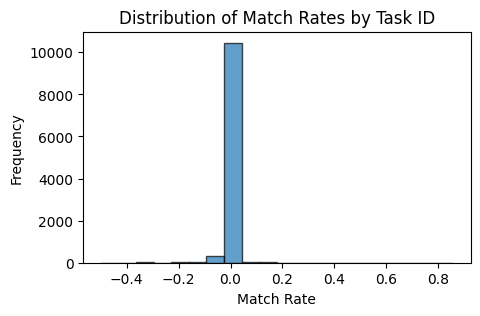

In [15]:
plt.figure(figsize=(5, 3))
plt.hist(label_rate_change_task.dropna(), bins = 20, edgecolor='k', alpha = 0.7)
plt.title('Distribution of Match Rates by Task ID')
plt.xlabel('Match Rate')
plt.ylabel('Frequency')
plt.show()

# 2 Machine Learning Tasks

In [16]:
columns_to_drop = [column for column in df_merged.columns if df_merged[column].nunique() > 13000 \
                   or df_merged[column].nunique() == 1]
df_merged = df_merged.drop(columns=columns_to_drop)
df_merged = df_merged.select_dtypes(include=[np.number])
#df_merged = df_merged.astype(int)

df_matched = df_merged.dropna()
match_rate = df_matched.shape[0]/df_merged.shape[0]
drop_rate = 1-match_rate
print("match rate:",match_rate)
print("drop rate:",drop_rate)

match rate: 0.8575759782696071
drop rate: 0.14242402173039292


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
#from pygam import LogisticGA
from xgboost import XGBClassifier
from nam.wrapper import NAMClassifier

models = {
    'LR': LogisticRegression(), # not accept nan
    'DT': DecisionTreeClassifier(random_state=0),
    'KNN': KNeighborsClassifier(), # not accept nan
    'NB': GaussianNB(), # not accept nan
    'SVM': SVC(random_state=0, probability=True), # not accept nan
    'RF': RandomForestClassifier(random_state=0),    
    #'GAM': LogisticGAM(), # Does not converge
    'XGB': XGBClassifier()#,
    #'NAM': NAMClassifier()
}

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/nam/trainer/trainer.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [18]:
from sklearn.model_selection import train_test_split

X_merged = df_merged.drop('label_x', axis=1) 
y_merged = df_merged['label_x']
X_matched = df_matched.drop('label_x', axis=1)
y_matched = df_matched['label_x']
X_train_merged, X_test_merged, y_train_merged, y_test_merged = \
        train_test_split(X_merged, y_merged, test_size=0.33, random_state=0)
X_train_matched, X_test_matched, y_train_matched, y_test_matched = \
        train_test_split(X_matched, y_matched, test_size=0.33, random_state=0)

In [19]:
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_curve, auc
from sklearn.metrics import f1_score,recall_score, precision_score

scaler_merged = StandardScaler()
X_train_merged = scaler_merged.fit_transform(X_train_merged)
X_test_merged = scaler_merged.transform(X_test_merged)

scaler_matched = StandardScaler()
X_train_matched = scaler_matched.fit_transform(X_train_matched)
X_test_matched = scaler_matched.transform(X_test_matched)

In [22]:
def get_metric_value(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    # Metric 1: accuracy
    accuracy = accuracy_score(y_test, y_pred)
    # Metric 2: ROC AUC
    auroc = roc_auc_score(y_test, y_proba)
    # Metric 3: F1 score
    f1 = f1_score(y_test, y_pred)
    # Metric 4: recall score
    recall = recall_score(y_test, y_pred) 
    # Metric 5: precision score
    precision = precision_score(y_test, y_pred)  
    # Metric 6: average_precision    
    ap = average_precision_score(y_test, y_proba)
    # Metric 7: confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    tpr = tp / (tp + fn)  
    fpr = fp / (fp + tn)  
    tnr = tn / (tn + fp)  
    fnr = fn / (tp + fn)
    
    return accuracy, auroc, f1, precision, recall, ap, tpr, fpr, tnr, fnr

In [27]:
columns=['Accuracy', 'AUC', 'F1', 'Recall','Precision', 'AP','TPR', 'FPR', 'TNR', 'FNR']
model_data = ['xgb_merged','xgb_matched','dt_merged','dt_matched']
result = pd.DataFrame(index = model_data, columns=columns)

In [23]:
xgb_merged = get_metric_value(XGBClassifier(), X_train_merged, X_test_merged, y_train_merged, y_test_merged)
xgb_matched = get_metric_value(XGBClassifier(), X_train_matched, X_test_matched, y_train_matched, y_test_matched)

In [32]:
result.loc['xgb_merged'] = xgb_merged
result.loc['xgb_matched'] = xgb_matched

In [25]:
dt_merged = get_metric_value(DecisionTreeClassifier(random_state=0), \
                             X_train_merged, X_test_merged, y_train_merged, y_test_merged)
dt_matched = get_metric_value(DecisionTreeClassifier(random_state=0), \
                             X_train_matched, X_test_matched, y_train_matched, y_test_matched)

In [33]:
result.loc['dt_merged'] = dt_merged
result.loc['dt_matched'] = dt_matched

In [37]:
rf_merged = get_metric_value(RandomForestClassifier(random_state=0), \
                             X_train_merged, X_test_merged, y_train_merged, y_test_merged)
rf_matched = get_metric_value(RandomForestClassifier(random_state=0), \
                             X_train_matched, X_test_matched, y_train_matched, y_test_matched)

In [38]:
result.loc['rf_merged'] = rf_merged
result.loc['rf_matched'] = rf_matched

In [40]:
result['Model'] = ['XGB','XGB','DT','DT','RF','RF']
result['Data'] = ['Merged','Matched','Merged','Matched','Merged','Matched']

In [41]:
result

,Accuracy,AUC,F1,Recall,Precision,AP,TPR,FPR,TNR,FNR,Model,Data
xgb_merged,0.984402,0.801927,0.014763,0.629787,0.007469,0.130843,0.007469,0.00007,0.99993,0.992531,XGB,Merged
xgb_matched,0.98702,0.773302,0.010459,0.659292,0.005271,0.087191,0.005271,0.000036,0.999964,0.994729,XGB,Matched
dt_merged,0.972278,0.60245,0.198443,0.181193,0.219323,0.052174,0.219323,0.015754,0.984246,0.780677,DT,Merged
dt_matched,0.975588,0.582406,0.159356,0.144371,0.177811,0.036502,0.177811,0.013894,0.986106,0.822189,DT,Matched
rf_merged,0.984711,0.765688,0.259451,0.535692,0.171179,0.213437,0.171179,0.002358,0.997642,0.828821,RF,Merged
rf_matched,0.986796,0.727719,0.219416,0.475522,0.142609,0.154797,0.142609,0.002074,0.997926,0.857391,RF,Matched
